# Material Identification

## Acknowledgements

I would like to give credit to Madjek, Inc. in Amityville, NY who provided the facilities for data collection and helped to advise in the business case scenario for this project. Although this scenario is a fictitious one, they were still happy to serve as an example for this data investigation, and we thank them for their support.

## Business Problem

To develop a Covolutional Nueral Network that can properly identify material types for warehouse and scrap material handling.

Our client Madjek, Inc. is a store fixture manufacturer who purchases a variety of sheet good materials for different jobs. They would like to install a material handling system which would keep track of their sheet good products in their warehouse.+ For the installation of this system, they would also like to eliminate barcodes and barcode scanners that would typically be used to track materials, so as to reduce the amount of employees required for material handling, as well as reduce human error in handling. In order to do this, they will need to have a system in place (using cameras and scanners) which would automatically recognize the type of material in a given situation. The system would need to recognize the material at certain intervals in material handling:

- When the material is offloaded from a truck and placed into the warehouse
- When the material is cut on the panel saw and then stored in with scrap cuts in the warehouse
- To serve as a quality control check at the CNC routers to confirm the correct material has been placed on the machine

The company has 4 main types of materials that they work with that they would like to have classified:

- MDF
- TFL / Particle Core with HPL
- Particle Core
- Veneer Core


## The Dataset

The images in this dataset contains around 2000 images that were taken at varying view points in both the warehouse and the scrap racks. All images were taken on a Iphone 13 pro camera. Across the range of images, there are a variety of lighting conditions, as well as a variety of close up and far away images. The far away images were taken within the warehouse, and are used to identify an entire stack of material, where the material will be the same for the entire stack. The close up images vary for both the warehouse and the scrap racks, where the piece of material that is centered in the image is what is identified as the material type. All original images in the dataset are located in images/Madjek_NoClass. There are other folders in images which were part of preprocessing, please see the first section of Preprocessing for more information on these folders.

There is also a Data_image_target csv file, which contains a column for the image file name, and a column for the material type of the image.

## Reading and Analyzing the Data

We will start by importing the libraries required for the notebook and pulling in the data as well as ignoring warning which were raised and addressed in completing the folowing notebook.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_theme()
sns.set(rc={'savefig.dpi':300, 'figure.figsize':(12,8)})
from tensorflow.keras.preprocessing import image
import tensorflow as tf
import os
import cv2
import argparse
import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import models
from keras import layers
from keras.models import Sequential
from tensorflow.keras.utils import plot_model
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

Lets take a look at some of the image files to get a better idea of the data we are working with.

In [2]:
def imgfileshow(filenames, directory, cols, rows):
    imgs = []
    fig, axes = plt.subplots(ncols=cols, nrows=rows, figsize=(12,12))
    for count, IM in enumerate(filenames):
        img = image.load_img((directory + '/' + IM), target_size=None)
        ax = axes[count//cols][count%cols]
        ax.imshow(img)
        ax.grid(False)
        imgs.append(img)

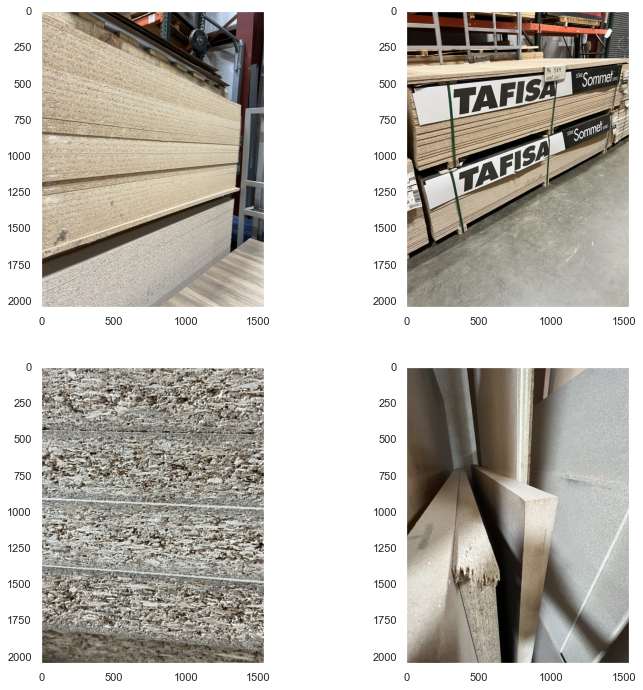

In [3]:
IMGtoLoad = ['IMG_1114.jpeg', 'IMG_1125.jpeg', 'IMG_1583.jpeg', 'IMG_1743.jpeg']

imgfileshow(IMGtoLoad, f'images/0_Madjek_NoClass', 2, 2)

We have a couple problems in these images that we will have to deal with. 

- The images are large (1536 x 2048), we will need to scale them down in order to reduce the modeling time
- Some images contain one piece of material and others contain a stack of material. By looking at the corresponding labels for the images, it looks like the material at the center of the image is what is being identified. We will need to crop the images to only include the center area of the image for proper identification
- Some images are close up and some images are taken far away. Not sure how we will deal with this, but will have to come back to it.



Lets take a look at the proportions of each of the classes we have in the csv file

In [4]:
df_target = pd.read_csv('images/Data_Image_Target.csv')
df_target

,IMG,Mat
0,IMG_1089,PC
1,IMG_1090,PC
2,IMG_1091,PC
3,IMG_1092,PC
4,IMG_1093,PC
...,...,...
2056,IMG_3148,TFL
2057,IMG_3149,TFL
2058,IMG_3150,TFL
2059,IMG_3151,TFL


In [5]:
print(df_target["Mat"].value_counts())

TFL    825
PC     619
MDF    309
VC     308
Name: Mat, dtype: int64


In [6]:
# Calculate percentages for each failure
Value_counts = df_target["Mat"].value_counts(normalize=True)*100
Vcts = [round(item, 2) for item in list(Value_counts.to_dict().values())]
Vcts

[40.03, 30.03, 14.99, 14.94]

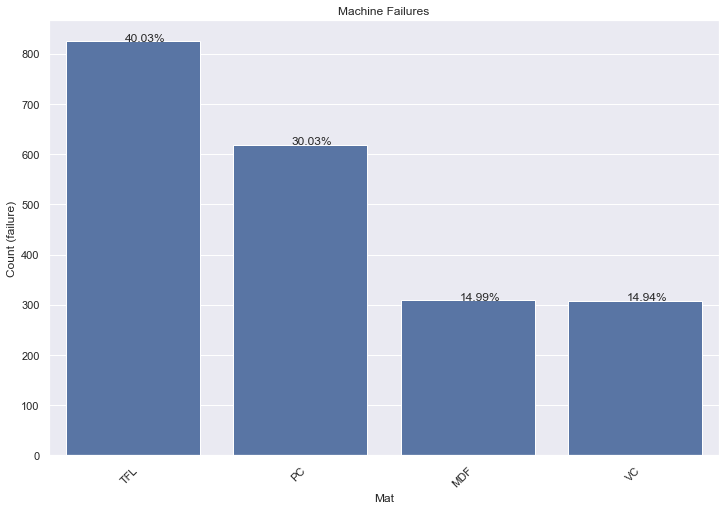

In [7]:
# Plot failure types and percentages in barplot

Mat_type = df_target['Mat'].value_counts(sort=True)
Value_counts = df_target["Mat"].value_counts(normalize=True)*100
vctsdict = Value_counts.to_numpy()

ax = sns.barplot(x=Mat_type.index, y=Mat_type.values, color='b')
ax.set(xlabel="Mat", ylabel="Count (failure)", title="Machine Failures")
plt.xticks(rotation=45, ha='right', rotation_mode="anchor")

for val, p in enumerate(ax.patches):
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate((str(Vcts[val]) + '%'), (x, y), size = 12)

The TFL class seems to have the most amount of data points at 40% of the entire dataset, with PC coming in second at 30% and MDF and VC coming in at 15%. So it seems that we have a slight class imbalance between them all. We may want to implement some techniques that will reduce the issues of this imbalance in the dataset.

## Preprocessing Data

### Nulls and count

Lets just double check the target data for any nulls or problems in that set before moving forward.

In [8]:
df_target.isnull().sum()

IMG    0
Mat    0
dtype: int64

In [9]:
df_target.describe()

,IMG,Mat
count,2061,2061
unique,2061,4
top,IMG_2149,TFL
freq,1,825


In [10]:
# folder path
dir_path = r'C:\Users\Tim\Documents\Flatiron\Phase_4\Material-Identification\images\0_Madjek_NoClass'
count = 0
# Iterate directory
for path in os.listdir(dir_path):
    # check if current path is a file
    if os.path.isfile(os.path.join(dir_path, path)):
        count += 1
print('File count:', count)

File count: 2061


There are no nulls in the csv file and the count of images matches the count of rows in the csv file. Lets analyze the images to see if there are any blurry images which would be problematic 

### Sample crop and resize

We will start by performing preprocessing on the four images we pulled as a sample from the dataset, once complete to the size we would like then we will then apply the preprocessing to the entire dataset

In [11]:
sam_imgs = [tf.io.decode_image((tf.io.read_file(f'images/0_Madjek_NoClass/{IM}')), channels=3, dtype=tf.dtypes.float32) for IM in IMGtoLoad]

In [12]:
crpimgs = tf.image.central_crop(sam_imgs, 0.4)

In [13]:
def tensorimgshow(filenames, cols, rows):
    imgs = []
    fig, axes = plt.subplots(ncols=cols, nrows=rows, figsize=(12,12))
    for count, IM in enumerate(filenames):
        img = image.array_to_img(IM)
        ax = axes[count//cols][count%cols]
        ax.imshow(img)
        ax.grid(False)
        imgs.append(img)

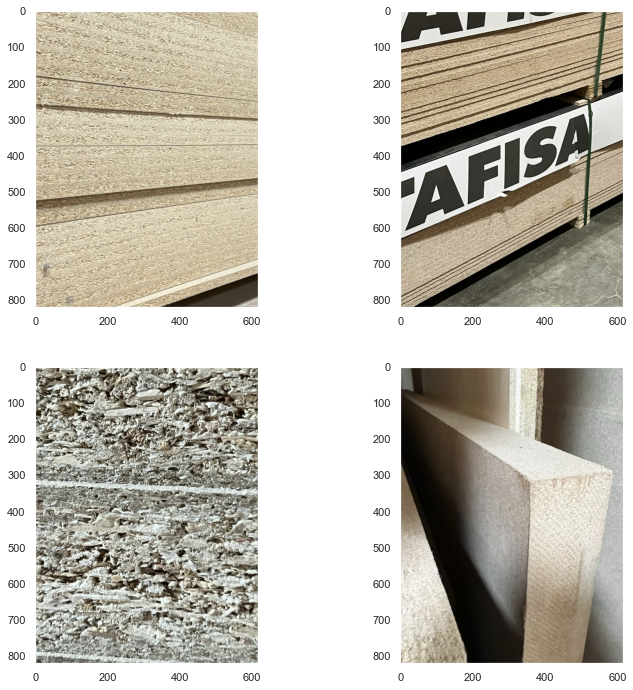

In [14]:
tensorimgshow(crpimgs, 2, 2)

IN order to futher improve processing time, we will also resize the dpi for the images

In [15]:
img_height = 256
img_width = 192

In [16]:
crpsizeimgs = tf.image.resize(crpimgs, [img_height, img_width])

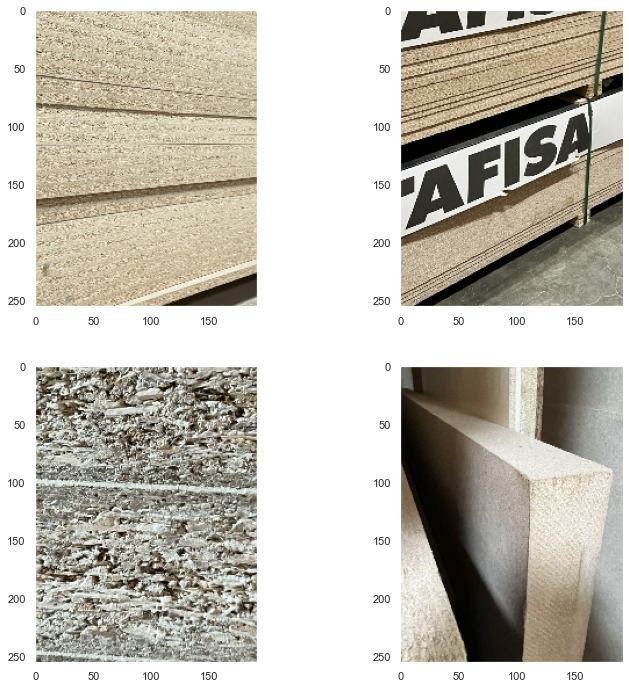

In [17]:
tensorimgshow(crpsizeimgs, 2, 2)

### Organizing images

| Folder Name  |  Description |
|---|---|
| 0_Madjek_NoClass  |   |
| 1A_Madjek_NoClass_Crop  |   |
| 1B_Madjek_Class_Crop  |   |
|  1C_Madjek_Crop |   |
| 2A_Madjek_Class  |   |
| 2B_Madjek  |   |




Under the images folder, each folder has an initial number and letter where the number represents the  The original Madjek_NoClass folder contains all of the original images for the project. A separate notebook named "Crop Images" was created in order to crop all original images similar to above and store the images in a new folder called "Madjek_Crop." Another notebook named "Train-Split-Multiclass-Images" was created to use the csv file to organize the images into subfolders by class (which were stored in the "Madjek_Class" folder) and then subsequently break the images into train, test, and validation sets (which were stored in the "Madjek" folder).

These files can be found here:



Now that our images are processed, we will take them and prepare them for modeling

## Preparing the Data for Modeling

Our images have been split beforehand into separate train, test, and validation folders. One thing we will need to do is assign these images to the proper variables in order to process them through our Convolutional Neural Network.

In [18]:
base_model0_train_dir = "images/1B_Madjek/train/"
base_model0_test_dir = "images/1B_Madjek/test/"
base_model0_val_dir = "images/1B_Madjek/val/"

In [19]:
batch_size =  32

In [20]:
# transfer data from directories to batches

base_model0_train_data = tf.keras.preprocessing.image_dataset_from_directory(
    base_model0_train_dir,
    batch_size = batch_size,
    image_size=(img_height, img_width),
    label_mode='categorical',
    seed = 42)

base_model0_test_data = tf.keras.preprocessing.image_dataset_from_directory(
    base_model0_test_dir,
    batch_size = batch_size,
    image_size=(img_height, img_width),
    label_mode='categorical',
    seed = 42)

base_model0_val_data = tf.keras.preprocessing.image_dataset_from_directory(
    base_model0_val_dir,                                               
    batch_size = batch_size,
    image_size=(img_height, img_width),
    label_mode='categorical',
    seed = 42)

Found 1648 files belonging to 4 classes.
Found 210 files belonging to 4 classes.
Found 203 files belonging to 4 classes.


In [21]:
for image_batch, labels_batch in base_model0_train_data:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 192, 3)
(32, 4)


In [22]:
classes=list(base_model0_train_data.class_names)
num_classes=len(classes)
num_classes

4

In [23]:
classes

['MDF', 'PC', 'TFL', 'VC']

## Baseline CNN

In [24]:
# Create baseline model
base_model0 = models.Sequential()

# Add the appropriate layers
base_model0.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(img_height, img_width, 3)))
base_model0.add(layers.MaxPooling2D())

base_model0.add(layers.Conv2D(32, (4, 4), activation='relu'))
base_model0.add(layers.MaxPooling2D())

base_model0.add(layers.Conv2D(64, (3, 3), activation='relu'))
base_model0.add(layers.MaxPooling2D())

base_model0.add(layers.Flatten())
base_model0.add(layers.Dense(64, activation='relu'))
base_model0.add(layers.Dense(num_classes, activation='softmax'))



In [25]:
# Compile the model
base_model0.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer="adam",
              metrics=['accuracy'])

In [26]:
# Return a summary of our model
base_model0.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 190, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 95, 32)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 124, 92, 32)       16416     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 46, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 44, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 22, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 42240)             0

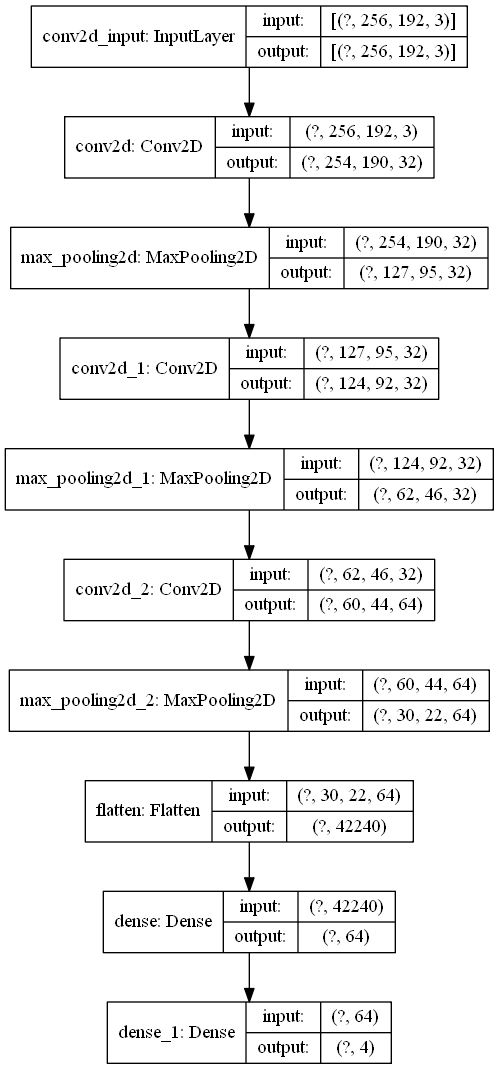

In [27]:
# Return image of model's architecture
plot_model(base_model0, show_shapes=True, show_layer_names=True)

In [42]:
epochs=10
bm0_history = base_model0.fit(
  base_model0_train_data,
  validation_data=base_model0_val_data,
  epochs=epochs
)

Epoch 1/10
52/52 [==============================] - 61s 1s/step - loss: 0.3555 - accuracy: 0.8786 - val_loss: 2.1044 - val_accuracy: 0.4384
Epoch 2/10
52/52 [==============================] - 61s 1s/step - loss: 0.2636 - accuracy: 0.9041 - val_loss: 2.3536 - val_accuracy: 0.4138
Epoch 3/10
52/52 [==============================] - 61s 1s/step - loss: 0.1766 - accuracy: 0.9466 - val_loss: 2.5367 - val_accuracy: 0.4335
Epoch 4/10
52/52 [==============================] - 60s 1s/step - loss: 0.1538 - accuracy: 0.9587 - val_loss: 2.4416 - val_accuracy: 0.4483
Epoch 5/10
52/52 [==============================] - 62s 1s/step - loss: 0.1266 - accuracy: 0.9606 - val_loss: 3.9360 - val_accuracy: 0.4433
Epoch 6/10
52/52 [==============================] - 62s 1s/step - loss: 0.1009 - accuracy: 0.9745 - val_loss: 3.3202 - val_accuracy: 0.4286
Epoch 7/10
52/52 [==============================] - 61s 1s/step - loss: 0.1035 - accuracy: 0.9691 - val_loss: 3.2622 - val_accuracy: 0.4828
Epoch 8/10
52/52 [==

In [43]:
base_model0.evaluate(base_model0_test_data)

7/7 [==============================] - 1s 116ms/step - loss: 4.1924 - accuracy: 0.5238


[4.192437648773193, 0.523809552192688]

In [44]:
def show_classification_report_and_confusion_matrix(model, batchDataset_test_data, classes, cmap, cm_title):
    y_pred = model.predict(batchDataset_test_data)
    predicted_categories = np.argmax(y_pred, axis = 1)
    true_categories = tf.concat([y for x, y in batchDataset_test_data], axis = 0).numpy() # convert to np array
    true_categories_argmax = np.argmax(true_categories, axis = 1)
    print(classification_report(true_categories_argmax, predicted_categories, target_names=classes))
    cm = confusion_matrix(true_categories_argmax, predicted_categories)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap = cmap)
    disp.ax_.set_title(cm_title)
    plt.grid(False)
    plt.show()

              precision    recall  f1-score   support

         MDF       0.22      0.19      0.20        32
          PC       0.35      0.22      0.27        63
         TFL       0.39      0.59      0.47        83
          VC       0.17      0.09      0.12        32

    accuracy                           0.34       210
   macro avg       0.28      0.27      0.27       210
weighted avg       0.32      0.34      0.32       210



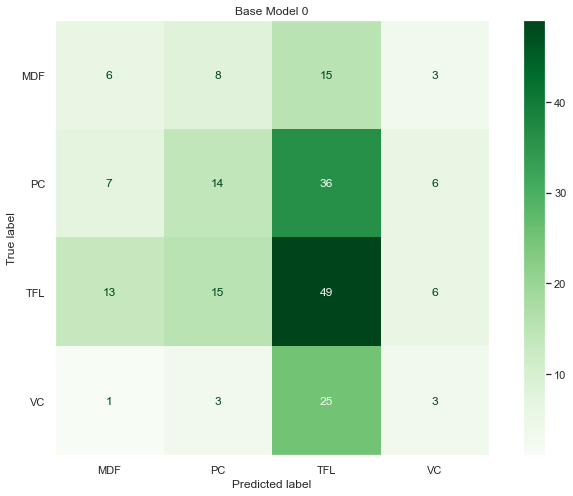

In [45]:
show_classification_report_and_confusion_matrix(base_model0, base_model0_test_data, classes, "Greens", "Base Model 0")

In [46]:
def visualize_training_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_accuracy', 'accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

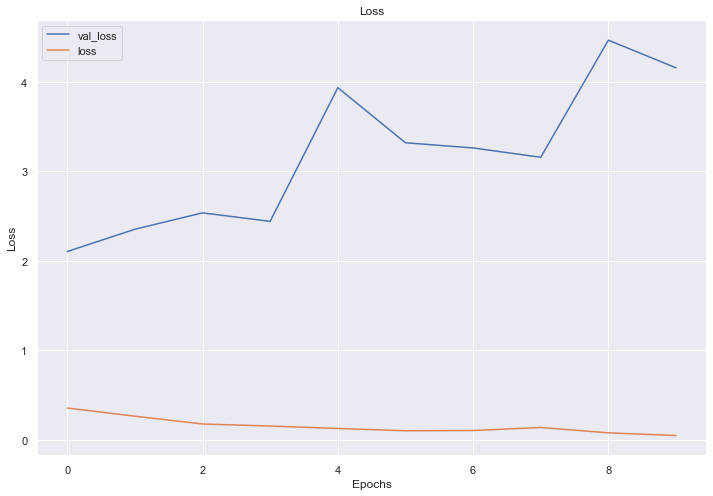

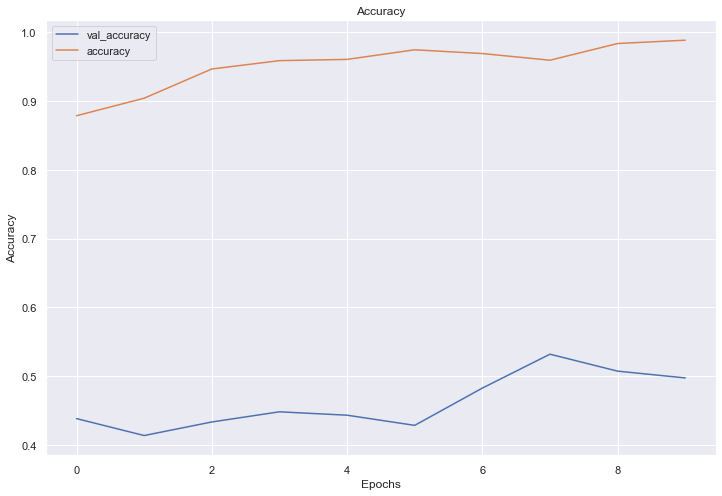

In [47]:
visualize_training_results(bm0_history)

Maybe we should try to use the pictures that are not cropped before fine tuning this model.

After cropping we looked through each of the images individually confirm that they showed the material that was identified originally. Photos were deleted from the set that had:
- More than one material in the image frame
- an material which did not match the true label
- did not show the edge of the material, which is requiired for identification

Images removed were the following:

In [ ]:
imgs_removed = ['IMG_2809', 'IMG_2810', 'IMG_1832', 'IMG_1833', 'IMG_2005', 'IMG_2049', 'IMG_2386', 
                'IMG_2415', 'IMG_2529', 'IMG_2532', 'IMG_2535', 'IMG_2536', 'IMG_2537', 'IMG_1480', 
                'IMG_1486', 'IMG_1487', 'IMG_1488', 'IMG_1489', 'IMG_1490', 'IMG_1491', 'IMG_1492', 
                'IMG_1493', 'IMG_1536', 'IMG_1537', 'IMG_1538', 'IMG_1542', 'IMG_1795', 'IMG_1796', 
                'IMG_1814', 'IMG_1904', 'IMG_2204', 'IMG_2249', 'IMG_2550', 'IMG_2573', 'IMG_1609',
                'IMG_1650', 'IMG_1694', 'IMG_1713', 'IMG_1829', 'IMG_2088', 'IMG_2417', 'IMG_2548', 
                'IMG_2610', 'IMG_2817', 'IMG_2826']

In [34]:
base_model1_train_dir = "images/2C_Madjek_Crop/train/"
base_model1_test_dir = "images/2C_Madjek_Crop/test/"
base_model1_val_dir = "images/2C_Madjek_Crop/val/"

In [35]:
# transfer data from directories to batches

base_model1_train_data = tf.keras.preprocessing.image_dataset_from_directory(
    base_model1_train_dir,
    batch_size = batch_size,
    image_size=(img_height, img_width),
    label_mode='categorical',
    seed = 42)

base_model1_test_data = tf.keras.preprocessing.image_dataset_from_directory(
    base_model1_test_dir,
    batch_size = batch_size,
    image_size=(img_height, img_width),
    label_mode='categorical',
    seed = 42)

base_model1_val_data = tf.keras.preprocessing.image_dataset_from_directory(
    base_model1_val_dir,                                               
    batch_size = batch_size,
    image_size=(img_height, img_width),
    label_mode='categorical',
    seed = 42)

Found 1609 files belonging to 4 classes.
Found 206 files belonging to 4 classes.
Found 199 files belonging to 4 classes.


In [36]:
# Create baseline model
base_model1 = models.Sequential()

# Add the appropriate layers
base_model1.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(img_height, img_width, 3)))
base_model1.add(layers.MaxPooling2D())

base_model1.add(layers.Conv2D(32, (4, 4), activation='relu'))
base_model1.add(layers.MaxPooling2D())

base_model1.add(layers.Conv2D(64, (3, 3), activation='relu'))
base_model1.add(layers.MaxPooling2D())

base_model1.add(layers.Flatten())
base_model1.add(layers.Dense(64, activation='relu'))
base_model1.add(layers.Dense(num_classes, activation='softmax'))



In [37]:
# Compile the model
base_model1.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer="adam",
              metrics=['accuracy'])

In [48]:
epochs=10
bm1_history = base_model1.fit(
  base_model1_train_data,
  validation_data=base_model1_val_data,
  epochs=epochs
)

Epoch 1/10
51/51 [==============================] - 37s 722ms/step - loss: 0.8022 - accuracy: 0.6706 - val_loss: 1.9956 - val_accuracy: 0.3668
Epoch 2/10
51/51 [==============================] - 37s 724ms/step - loss: 0.8428 - accuracy: 0.6513 - val_loss: 1.7048 - val_accuracy: 0.3769
Epoch 3/10
51/51 [==============================] - 36s 716ms/step - loss: 0.8223 - accuracy: 0.6476 - val_loss: 2.0900 - val_accuracy: 0.3920
Epoch 4/10
51/51 [==============================] - 37s 720ms/step - loss: 0.7803 - accuracy: 0.6899 - val_loss: 2.4504 - val_accuracy: 0.4020
Epoch 5/10
51/51 [==============================] - 37s 718ms/step - loss: 0.7256 - accuracy: 0.7129 - val_loss: 2.6216 - val_accuracy: 0.3970
Epoch 6/10
51/51 [==============================] - 37s 718ms/step - loss: 0.7027 - accuracy: 0.7166 - val_loss: 2.7876 - val_accuracy: 0.3970
Epoch 7/10
51/51 [==============================] - 37s 722ms/step - loss: 0.5868 - accuracy: 0.7651 - val_loss: 2.5884 - val_accuracy: 0.3819

In [49]:
base_model1.evaluate(base_model1_test_data)

7/7 [==============================] - 1s 114ms/step - loss: 3.9318 - accuracy: 0.3398


[3.931774854660034, 0.33980581164360046]

              precision    recall  f1-score   support

         MDF       0.11      0.06      0.08        32
          PC       0.31      0.21      0.25        62
         TFL       0.40      0.65      0.50        81
          VC       0.14      0.06      0.09        31

    accuracy                           0.34       206
   macro avg       0.24      0.25      0.23       206
weighted avg       0.29      0.34      0.30       206



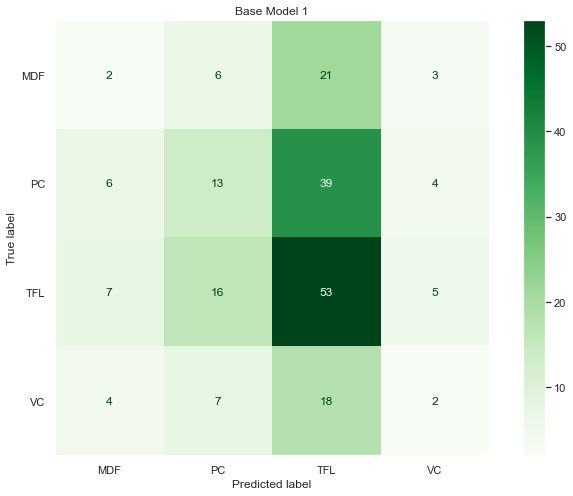

In [40]:
show_classification_report_and_confusion_matrix(base_model1, base_model1_test_data, classes, "Greens", "Base Model 1")

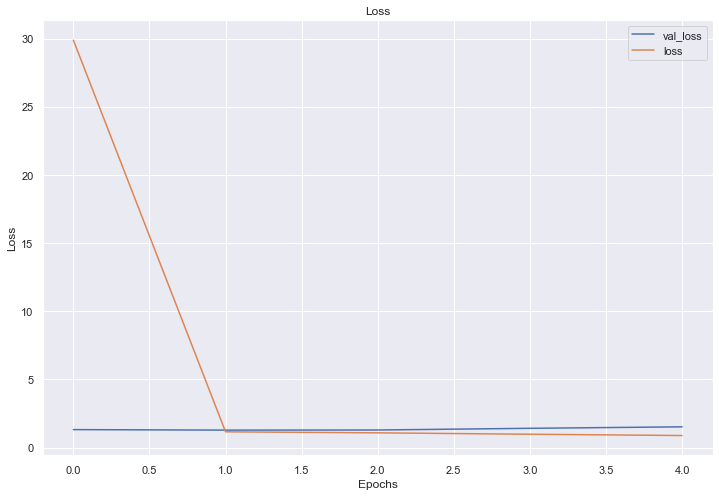

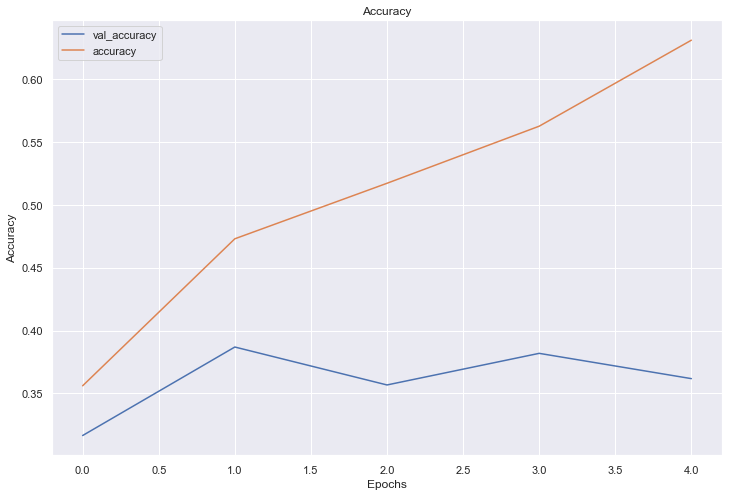

In [41]:
visualize_training_results(bm1_history)

Seems that base model 0  performed better than base model 1. Which is interesting considering that we would have thought the cropped images for base model 1 would actually assist in helping the performance of the model. Nonetheless, we will move forward using base model 0 as our baseline model.

## CNN with Regularization

In [53]:

data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

# Create regularized model with dropout
reg_model0 = models.Sequential([data_augmentation])

# Add the appropriate layers
reg_model0.add(layers.Conv2D(16, kernel_size=(3, 3), activation='relu', 
                        input_shape=(img_height, img_width, 3)))
reg_model0.add(layers.MaxPooling2D(pool_size=(2, 2)))

reg_model0.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
reg_model0.add(layers.MaxPooling2D(pool_size=(2, 2)))

reg_model0.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu'))
reg_model0.add(layers.MaxPooling2D(pool_size=(2, 2)))

reg_model0.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu'))
reg_model0.add(layers.MaxPooling2D(pool_size=(2, 2)))

reg_model0.add(layers.Flatten())
reg_model0.add(layers.Dense(512, activation='relu'))
reg_model0.add(layers.Dropout(0.3))
reg_model0.add(layers.Dense(512, activation='relu'))
reg_model0.add(layers.Dropout(0.3))
reg_model0.add(layers.Dense(num_classes, activation='softmax'))

# Compile the model
reg_model0.compile(loss='categorical_crossentropy',
              optimizer='RMSprop',
              metrics=['accuracy'])


In [54]:
epochs=10
rm0_history = reg_model0.fit(
  base_model0_train_data,
  validation_data=base_model0_val_data,
  epochs=epochs
)

Epoch 1/10
52/52 [==============================] - 63s 1s/step - loss: 37.0021 - accuracy: 0.3562 - val_loss: 1.5308 - val_accuracy: 0.3054
Epoch 2/10
52/52 [==============================] - 62s 1s/step - loss: 2.2336 - accuracy: 0.3835 - val_loss: 1.2776 - val_accuracy: 0.4138
Epoch 3/10
52/52 [==============================] - 62s 1s/step - loss: 1.6737 - accuracy: 0.3847 - val_loss: 3.2323 - val_accuracy: 0.1724
Epoch 4/10
52/52 [==============================] - 62s 1s/step - loss: 1.4102 - accuracy: 0.4005 - val_loss: 4.2262 - val_accuracy: 0.4039
Epoch 5/10
52/52 [==============================] - 66s 1s/step - loss: 1.3725 - accuracy: 0.4126 - val_loss: 1.3272 - val_accuracy: 0.3892
Epoch 6/10
52/52 [==============================] - 62s 1s/step - loss: 1.3539 - accuracy: 0.4090 - val_loss: 1.2720 - val_accuracy: 0.4335
Epoch 7/10
52/52 [==============================] - 62s 1s/step - loss: 1.3912 - accuracy: 0.4078 - val_loss: 1.2559 - val_accuracy: 0.3990
Epoch 8/10
52/52 [=

In [49]:
reg_model0.evaluate(base_model0_test_data)

7/7 [==============================] - 1s 114ms/step - loss: 3.9318 - accuracy: 0.3398


[3.931774854660034, 0.33980581164360046]

              precision    recall  f1-score   support

         MDF       0.11      0.06      0.08        32
          PC       0.31      0.21      0.25        62
         TFL       0.40      0.65      0.50        81
          VC       0.14      0.06      0.09        31

    accuracy                           0.34       206
   macro avg       0.24      0.25      0.23       206
weighted avg       0.29      0.34      0.30       206



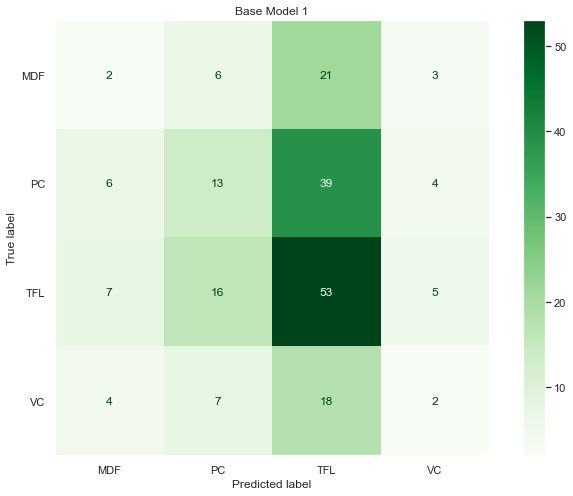

In [40]:
show_classification_report_and_confusion_matrix(reg_model0, base_model0_test_data, classes, "Greens", "Regularization Model 0")

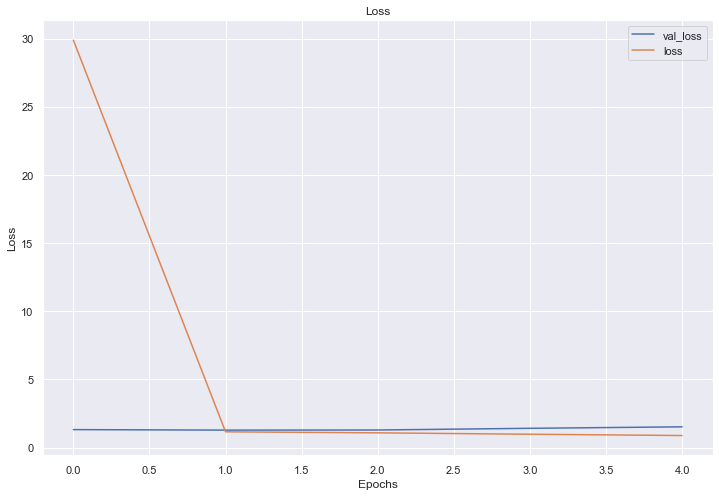

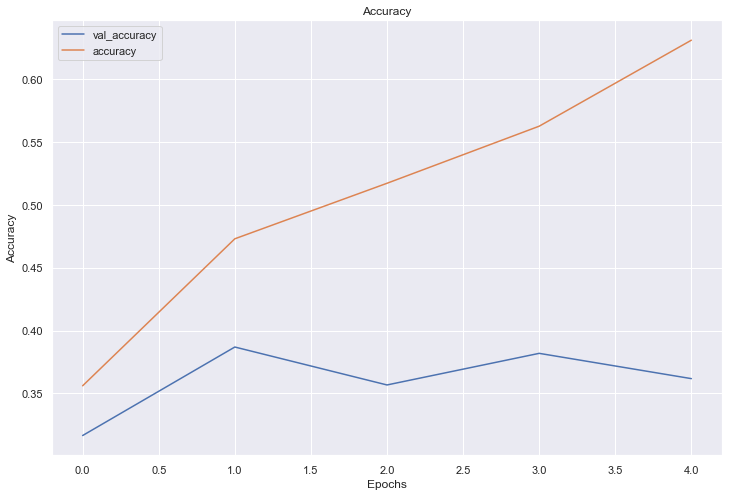

In [41]:
visualize_training_results(rm0_history)

## Fine-Tuning and Refitting

In [ ]:
initial_epochs = 10
fine_tune_epochs = initial_epochs + 1

# Refit the model
history_2 = model_0.fit(train_data,
                       epochs = fine_tune_epochs,
                       validation_data = val_data,
                       validation_steps = int(0.25*len(val_data)),
                       initial_epoch =  history.epoch[-1],) # Start the epoch where it left before

## Transfer Learning

In [58]:
from keras.applications import ResNet50V2

cnn_base = ResNet50V2(weights='imagenet', 
                 include_top=False,
                 input_shape=(img_height, img_width, 3))

transfer_model0 = models.Sequential()
transfer_model0.add(cnn_base)
transfer_model0.add(layers.Flatten())
transfer_model0.add(layers.Dense(64, activation='relu'))
transfer_model0.add(layers.Dense(128, activation='relu'))
transfer_model0.add(layers.Dense(256, activation='relu'))
transfer_model0.add(layers.Dense(128, activation='relu'))
transfer_model0.add(layers.Dense(num_classes, activation='softmax'))

cnn_base.trainable = False


In [59]:
# Compile the model
transfer_model0.compile(loss='categorical_crossentropy',
              optimizer='RMSprop',
              metrics=['accuracy'])

In [60]:
epochs=10
tm0_history = transfer_model0.fit(
  base_model0_train_data,
  validation_data=base_model0_val_data,
  epochs=epochs
)

Epoch 1/10
52/52 [==============================] - 86s 2s/step - loss: 208.3233 - accuracy: 0.3556 - val_loss: 1.3422 - val_accuracy: 0.4039
Epoch 2/10
52/52 [==============================] - 85s 2s/step - loss: 1.4372 - accuracy: 0.4005 - val_loss: 1.2988 - val_accuracy: 0.4039
Epoch 3/10
52/52 [==============================] - 85s 2s/step - loss: 1.2994 - accuracy: 0.4005 - val_loss: 1.2932 - val_accuracy: 0.4039
Epoch 4/10
52/52 [==============================] - 83s 2s/step - loss: 1.2975 - accuracy: 0.4005 - val_loss: 1.2961 - val_accuracy: 0.4039
Epoch 5/10
52/52 [==============================] - 83s 2s/step - loss: 1.2989 - accuracy: 0.4005 - val_loss: 1.2952 - val_accuracy: 0.4039
Epoch 6/10
52/52 [==============================] - 83s 2s/step - loss: 1.2978 - accuracy: 0.4005 - val_loss: 1.2942 - val_accuracy: 0.4039
Epoch 7/10
52/52 [==============================] - 87s 2s/step - loss: 1.2990 - accuracy: 0.4005 - val_loss: 1.2948 - val_accuracy: 0.4039
Epoch 8/10
52/52 [